# Data Analysis & Feature Engineering

Merge business and market data, engineer features, and perform exploratory analysis.

**Features to Engineer:**
1. Revenue Growth Potential (market trends vs current revenue)
2. Risk Score (regulatory constraints + competition)
3. Digital Readiness (online presence + customer age distribution)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

## 1. Load & Merge Data

In [3]:
# Load datasets
business_df = pd.read_csv('../data/raw/business_data.csv')
market_df = pd.read_csv('../data/raw/market_data.csv')

print(f"Business data: {business_df.shape}")
print(f"Market data: {market_df.shape}")

Business data: (50000, 11)
Market data: (225, 8)


In [4]:
# Parse age distribution and extract young customer percentage
business_df['Age_Distribution'] = business_df['Customer_Age_Distribution'].apply(eval)
business_df['Pct_Young_Customers'] = business_df['Age_Distribution'].apply(
    lambda x: x.get('18-25', 0) + x.get('26-40', 0)
)

# Merge on Industry and Location
merged_df = business_df.merge(market_df, on=['Industry', 'Location'], how='left')
print(f"\nMerged shape: {merged_df.shape}")
print(f"Missing market data: {merged_df['Consumer_Spending_Growth_YoY'].isna().sum()} rows")


Merged shape: (50000, 19)
Missing market data: 0 rows


## 2. Feature Engineering

In [5]:
# Feature 1: Revenue Growth Potential
# Calculate revenue percentile within industry
industry_revenues = merged_df.groupby('Industry')['Revenue_Last_12M'].apply(list).to_dict()
merged_df['Revenue_Percentile'] = merged_df.apply(
    lambda row: stats.percentileofscore(industry_revenues[row['Industry']], row['Revenue_Last_12M']),
    axis=1
)

# Normalize components to 0-100
growth_map = {'Declining': 0, 'Stable': 50, 'Growing': 100}
merged_df['Industry_Growth_Score'] = merged_df['Industry_Growth_Trend'].map(growth_map)

spending_min = merged_df['Consumer_Spending_Growth_YoY'].min()
spending_max = merged_df['Consumer_Spending_Growth_YoY'].max()
merged_df['Consumer_Spending_Score'] = (
    (merged_df['Consumer_Spending_Growth_YoY'] - spending_min) / (spending_max - spending_min) * 100
)

# Combined score: high market growth + low current revenue = high potential
merged_df['Revenue_Growth_Potential'] = (
    0.4 * merged_df['Consumer_Spending_Score'] +
    0.4 * merged_df['Industry_Growth_Score'] +
    0.2 * (100 - merged_df['Revenue_Percentile'])
).round(2)

print(f"Revenue Growth Potential - Mean: {merged_df['Revenue_Growth_Potential'].mean():.1f}")

Revenue Growth Potential - Mean: 56.2


In [6]:
# Feature 2: Risk Score
# Regulatory risk from keyword count
risk_keywords = ['strict', 'compliance', 'penalties', 'fines', 'violation', 'mandatory', 'regulated']
merged_df['Regulatory_Risk'] = merged_df['Regulatory_Constraints'].apply(
    lambda text: min(sum(1 for kw in risk_keywords if kw in str(text).lower()) * 10, 100)
)

# Competition risk
comp_min = merged_df['Competition_Density_Score'].min()
comp_max = merged_df['Competition_Density_Score'].max()
merged_df['Competition_Risk'] = (
    (merged_df['Competition_Density_Score'] - comp_min) / (comp_max - comp_min) * 100
).fillna(50)

# Industry decline risk
industry_risk_map = {'Growing': 0, 'Stable': 30, 'Declining': 100}
merged_df['Industry_Risk'] = merged_df['Industry_Growth_Trend'].map(industry_risk_map)

# Combined Risk Score
merged_df['Risk_Score'] = (
    0.35 * merged_df['Competition_Risk'] +
    0.35 * merged_df['Regulatory_Risk'] +
    0.30 * merged_df['Industry_Risk']
).round(2)

print(f"Risk Score - Mean: {merged_df['Risk_Score'].mean():.1f}")

Risk Score - Mean: 32.3


In [7]:
# Feature 3: Digital Readiness
online_map = {'Low': 0, 'Medium': 50, 'High': 100}
payment_map = {'Cash-only': 0, 'Basic': 33, 'Intermediate': 67, 'Advanced': 100}

merged_df['Online_Score'] = merged_df['Online_Presence'].map(online_map)
merged_df['Payment_Score'] = merged_df['Digital_Payment_Adoption'].map(payment_map)

# Combined score: online presence + payment adoption + young customers
merged_df['Digital_Readiness'] = (
    0.4 * merged_df['Online_Score'] +
    0.3 * merged_df['Payment_Score'] +
    0.3 * merged_df['Pct_Young_Customers']
).round(2)

print(f"Digital Readiness - Mean: {merged_df['Digital_Readiness'].mean():.1f}")
print("\nFeature engineering complete!")

Digital Readiness - Mean: 49.4

Feature engineering complete!


## 3. Exploratory Data Analysis

In [8]:
# Descriptive statistics
features = ['Revenue_Growth_Potential', 'Risk_Score', 'Digital_Readiness']
print("Engineered Features Summary:")
print("=" * 70)
print(merged_df[features].describe())

Engineered Features Summary:
       Revenue_Growth_Potential    Risk_Score  Digital_Readiness
count              50000.000000  50000.000000       50000.000000
mean                  56.175636     32.315467          49.374907
std                   21.264510      9.415596          20.260117
min                    0.000000      9.000000          11.610000
25%                   42.450000     26.250000          34.100000
50%                   54.050000     30.880000          47.120000
75%                   74.850000     35.250000          66.310000
max                   98.430000     67.620000          94.300000


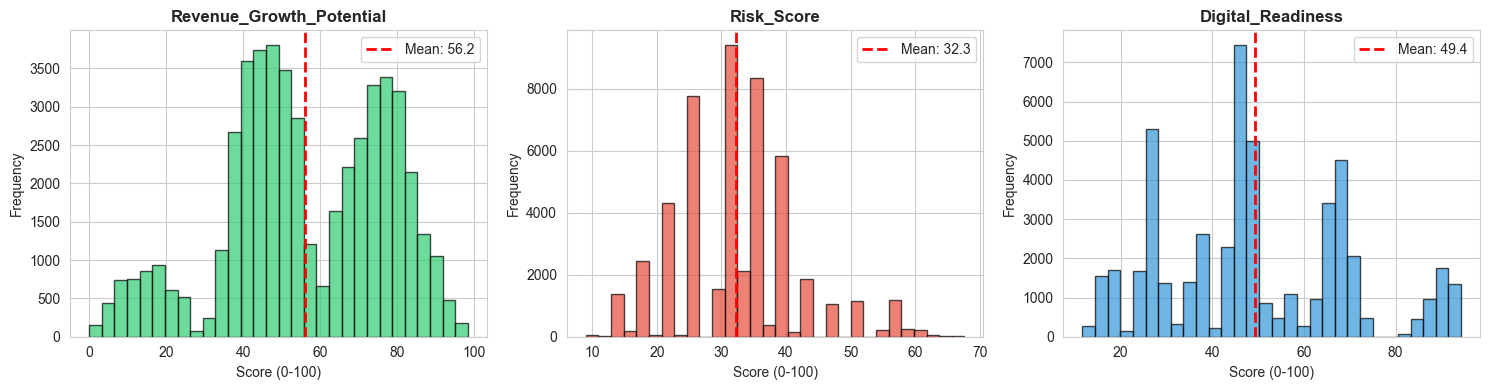

In [9]:
# Distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['#2ecc71', '#e74c3c', '#3498db']
for idx, feature in enumerate(features):
    axes[idx].hist(merged_df[feature], bins=30, color=colors[idx], edgecolor='black', alpha=0.7)
    axes[idx].axvline(merged_df[feature].mean(), color='red', linestyle='--', linewidth=2, 
                     label=f'Mean: {merged_df[feature].mean():.1f}')
    axes[idx].set_title(feature, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Score (0-100)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()
plt.show()

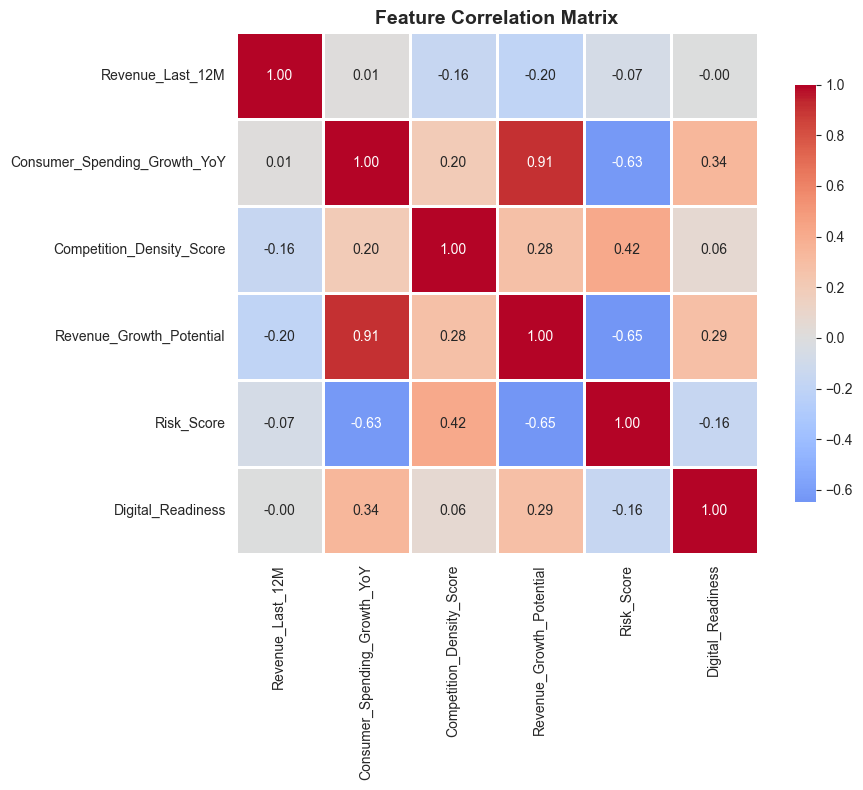

In [10]:
# Correlation heatmap
corr_cols = ['Revenue_Last_12M', 'Consumer_Spending_Growth_YoY', 'Competition_Density_Score',
             'Revenue_Growth_Potential', 'Risk_Score', 'Digital_Readiness']

corr_matrix = merged_df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

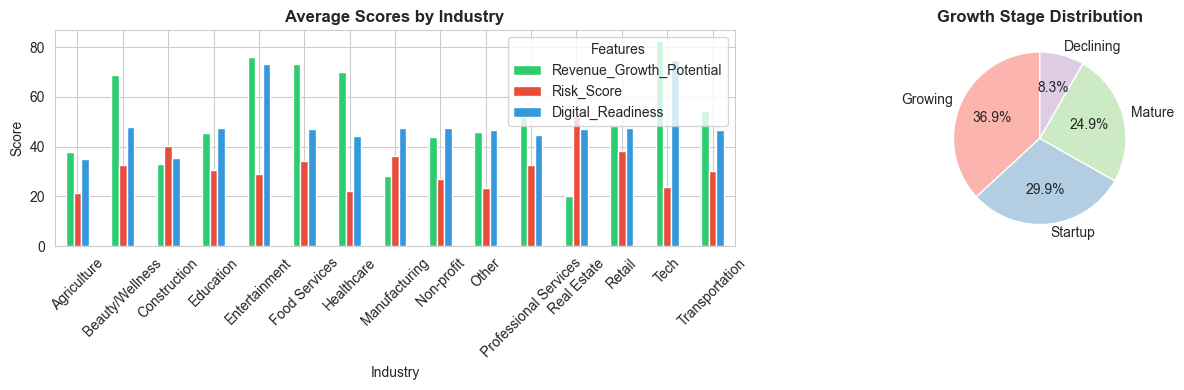

In [11]:
# Industry & Growth Stage breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Average scores by industry
industry_scores = merged_df.groupby('Industry')[features].mean()
industry_scores.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#3498db'])
axes[0].set_title('Average Scores by Industry', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Industry')
axes[0].set_ylabel('Score')
axes[0].legend(title='Features', loc='upper right')
axes[0].tick_params(axis='x', rotation=45)

# Growth stage distribution
growth_counts = merged_df['Growth_Stage'].value_counts()
axes[1].pie(growth_counts.values, labels=growth_counts.index, autopct='%1.1f%%', 
           startangle=90, colors=plt.cm.Pastel1.colors)
axes[1].set_title('Growth Stage Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Export Engineered Dataset

In [12]:
# Select columns for export
export_cols = [
    'Business_ID', 'Industry', 'Revenue_Last_12M', 'Location', 'Growth_Stage',
    'Online_Presence', 'Digital_Payment_Adoption', 'Regulatory_Constraints',
    'IG_Comments', 'Main_Challenges', 'Pct_Young_Customers',
    'Consumer_Spending_Growth_YoY', 'Competition_Density_Score', 'Industry_Growth_Trend',
    'Revenue_Growth_Potential', 'Risk_Score', 'Digital_Readiness'
]

engineered_df = merged_df[export_cols].copy()
engineered_df.to_csv('../data/processed/engineered_business_data.csv', index=False)

print(f"✓ Exported: ../data/processed/engineered_business_data.csv")
print(f"✓ Shape: {engineered_df.shape}")
print(f"\nSample rows:")
engineered_df.head(3)

✓ Exported: ../data/processed/engineered_business_data.csv
✓ Shape: (50000, 17)

Sample rows:


,Business_ID,Industry,Revenue_Last_12M,Location,Growth_Stage,Online_Presence,Digital_Payment_Adoption,Regulatory_Constraints,IG_Comments,Main_Challenges,Pct_Young_Customers,Consumer_Spending_Growth_YoY,Competition_Density_Score,Industry_Growth_Trend,Revenue_Growth_Potential,Risk_Score,Digital_Readiness
0,ce0d782b-fc0a-4120-aa13-b056632e68bb,Beauty/Wellness,119496,"New York, NY, USA",Startup,Medium,Basic,A software development company in Ukraine is s...,New parents are thankful for the helpful and s...,['Maintaining journalistic integrity and ethic...,58.0,4.1,9,Stable,47.95,39.62,47.30
1,a3e4720e-1715-407e-9686-2352552d2a98,Food Services,60000,"Mumbai, Maharashtra, India",Growing,Medium,Basic,Australian businesses must adhere to the Austr...,Fashionistas are loving the trendy and afforda...,['Maintaining journalistic integrity and ethic...,54.5,9.2,10,Growing,91.51,35.00,46.25
2,97b5352e-e37f-4fed-bd46-fa5a47ff6e54,Beauty/Wellness,315606,"Paris, France",Growing,Medium,Advanced,Companies in Finland must comply with data pro...,Customers appreciate the variety of craft beer...,['Scaling the customer support team to meet gr...,56.6,5.2,9,Growing,63.72,30.62,66.98


In [13]:
# Summary
print(f"\n✓ Merged {len(engineered_df):,} business profiles with market data")
print(f"\n✓ Engineered 3 key features:")
print(f"  1. Revenue Growth Potential (mean: {engineered_df['Revenue_Growth_Potential'].mean():.1f})")
print(f"  2. Risk Score (mean: {engineered_df['Risk_Score'].mean():.1f})")
print(f"  3. Digital Readiness (mean: {engineered_df['Digital_Readiness'].mean():.1f})")
print(f"\n✓ Generated EDA visualizations (distributions, correlations, industry breakdown)")
print(f"\n✓ Exported engineered dataset for model training")


✓ Merged 50,000 business profiles with market data

✓ Engineered 3 key features:
  1. Revenue Growth Potential (mean: 56.2)
  2. Risk Score (mean: 32.3)
  3. Digital Readiness (mean: 49.4)

✓ Generated EDA visualizations (distributions, correlations, industry breakdown)

✓ Exported engineered dataset for model training
